In [1]:
# Study of the effect of temperature and soot thickness on the antenna frequencies. 
# This custom implementation will be used to compare the output with the Scikit-Learn model.
# See publication: Microstrip patch antenna for simultaneous temperature sensing and superstrate characterization

In [2]:
from DWAS_Utils_with_CV import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=6)
np.random.seed(42)
%matplotlib inline

In [3]:
# LOAD DATA FROM THE EXCEL OR TXT FILE
df = pd.read_csv('T_h_ff_data.csv')
df.head(5)

,Temperature,Superstrate_thickness,Frequency10,Frequency01
0,22.980204,0,2.549826,3.293016
1,23.159179,0,2.549910,3.293125
2,22.926659,0,2.549801,3.292983
3,22.923294,0,2.549799,3.292981
4,22.968323,0,2.549820,3.293008


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875000 entries, 0 to 874999
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Temperature            875000 non-null  float64
 1   Superstrate_thickness  875000 non-null  int64  
 2   Frequency10            875000 non-null  float64
 3   Frequency01            875000 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 26.7 MB


In [5]:
# VISUALIZE INPUTS AND TARGETS
# Domain knowledge: Sooth thickness and temperature changes affect both sensor frequencies. The sensor resonates at two
# frequencies f10 and f01. There are two inputs (Superstrate_thickness and temperature) and two outputs (f10 and f01)
h = df['Superstrate_thickness']
T = df['Temperature'] 
f10 = df['Frequency10']
f01 = df['Frequency01']

In [6]:
X = np.c_[T, h]  # # Input with 2 features
Y = np.c_[f10, f01]  # Targets
print(f'Multioutput target shape: {Y.shape}')

Multioutput target shape: (875000, 2)


Text(0.5, 0.98, 'Sensor frequencies vs. soot and temperature change')

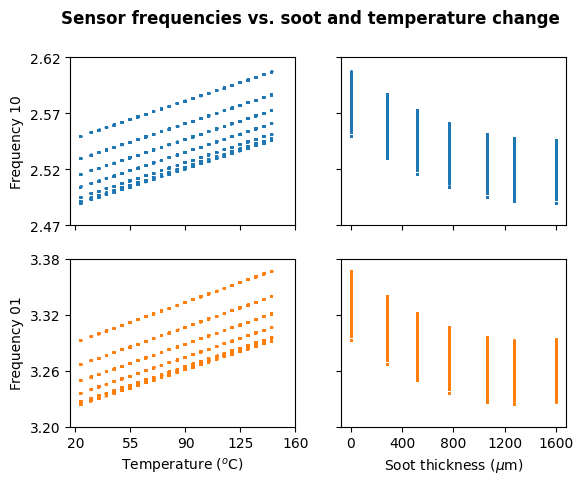

In [7]:
# Visualizing data
colors = ['#1f77b4', '#ff7f0e']
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
for j in range(2):
    for i, a in enumerate(ax[j]):
        a.plot(X[:, i], Y[:, j], '.', markersize=1, color=colors[j])

ax[1, 0].set_xlabel('Temperature ($^o$C)')
ax[1, 1].set_xlabel('Soot thickness ($\\mu$m)')
ax[0, 0].set_ylabel('Frequency 10')
ax[1, 0].set_ylabel('Frequency 01')

ax[1, 0].set_xticks(np.linspace(20, 160, 5))
ax[1, 1].set_xticks(np.linspace(0, 1600, 5))
ax[0, 0].set_yticks(np.linspace(2.47, 2.62, 4))
ax[1, 0].set_yticks(np.linspace(3.2, 3.38, 4))
fig.suptitle('Sensor frequencies vs. soot and temperature change', weight='bold')

In [8]:
# As shown and from knowledge of previous studies, the frequencies are linear functions of the temperature.
# At constant sooth thickness, the frequencies increase linearly with temperature change. At constant 
# temperature, the best fit for soot thickness is a second-order polynomial. We need feature engineering.

# FEATURE ENGINEERING, DATA SPLIT, AND FEATURE SCALING
# Feature engineering
X_mapped = np.c_[h, h ** 2, T * h, T]  # see previous studies to understand this selection

# Splitting raw data into training (60%), CV (20%), and test sets (20%).
X_train_mapped, X_, Y_train, Y_ = train_test_split(X_mapped, Y, train_size=0.8, random_state=42)
X_cv_mapped, X_test_mapped, Y_cv, Y_test = train_test_split(X_, Y_, train_size=0.5, random_state=42)
del (X_, Y_)

# Feature scaling
X_train_mapped_scaled, mean, sigma = zscore_normalization(X_train_mapped)
X_cv_mapped_scaled = (X_cv_mapped - mean) / sigma  # Applying the same normalization to the cv dataset
X_test_mapped_scaled = (X_test_mapped - mean) / sigma  # Applying the same normalization to the test dataset

print(f'Peak to Peak range by column in raw training set:{np.ptp(X_train_mapped, axis=0)}')
print(f'Peak to Peak range by column in normalized training set:{np.ptp(X_train_mapped_scaled, axis=0)}')

Peak to Peak range by column in raw training set:[1.600000e+03 2.560000e+06 2.315252e+05 1.221285e+02]
Peak to Peak range by column in normalized training set:[3.056055 2.943565 4.148984 3.379684]


Epoch #: 0 Train cost: 6.181978e-02 CV cost: 4.150932e-01
Epoch #: 5 Train cost: 5.559253e-12 CV cost: 8.691611e-13
Epoch #: 9 Train cost: 6.514464e-12 CV cost: 9.733323e-17


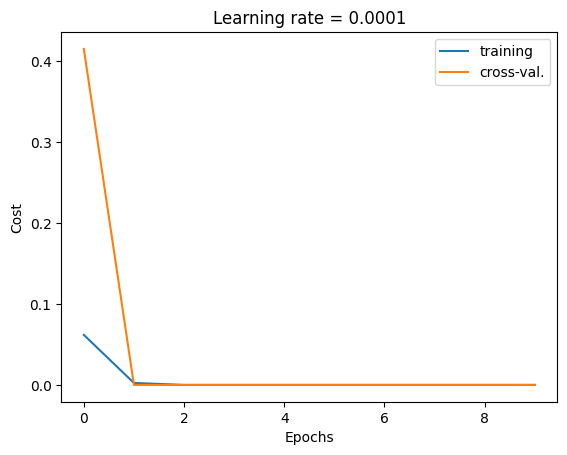

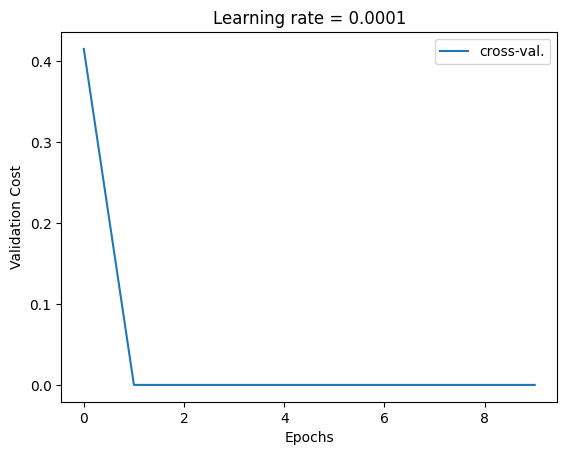

In [9]:
# Train the model
parameters = model_with_cv(X_train_mapped_scaled, Y_train, X_cv_mapped_scaled, Y_cv,
                           optimizer='adam', learning_rate=1e-4, mini_batch_size=32,
                           num_epochs=10, decay=None)

In [10]:
parameters

{'W11': -0.04133957054666762,
 'W12': 0.02268161131740825,
 'W13': -0.00037131214414098344,
 'W14': 0.01702369839726568,
 'W21': -0.05366395511355445,
 'W22': 0.03383978814851352,
 'W23': -0.0022605653281796896,
 'W24': 0.022039391685429875,
 'b1': 2.539527671498206,
 'b2': 3.2819389242434505}

In [11]:
# Simplified parameter retrieval
targets = Y.shape[1] 
features = X_mapped.shape[1]
W_flat = np.array([parameters[f'W{i}{j}'] for i in range(1, targets + 1) for j in range(1, features + 1)])
W = W_flat.reshape(targets, features)
b = np.array([parameters[f'b{i}'] for i in range(1, targets + 1)])

# Compute scores and costs
Jtrain, _ = compute_cost_multioutput(X_train_mapped_scaled, Y_train, W, b)
Jcv, _ = compute_cost_multioutput(X_cv_mapped_scaled, Y_cv, W, b)
Jtest, _ = compute_cost_multioutput(X_test_mapped_scaled, Y_test, W, b)
score = model_score(X_test_mapped_scaled, Y_test, parameters)

In [12]:
print("Training cost: %e, Validation cost: %e, Test cost: %e" % (Jtrain, Jcv, Jtest))
print(f"Model score: {score}")
print(f"W: {W}")
print(f"b: {b}")

Training cost: 9.710037e-17, Validation cost: 9.733323e-17, Test cost: 9.719660e-17
Model score: 0.9999999999998168
W: [[-0.04134   0.022682 -0.000371  0.017024]
 [-0.053664  0.03384  -0.002261  0.022039]]
b: [2.539528 3.281939]


In [13]:
# The performance is similar to that obtained using Scikit-Learn. See below.
# Training cost: 4.162770e-20, Test cost: 4.183898e-20
# Model score: 0.9999999999999999
# W: [[-0.041326  0.022676 -0.000371  0.017025]
#  [-0.053646  0.033832 -0.002261  0.022042]]
# b: [2.539521 3.28193 ]